In [1]:
from torchvision.datasets import ImageFolder
import random
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip
from torchvision.transforms import ToTensor, Normalize, Resize, Lambda

Train_Folder = '/home/enitt/Desktop/Train_Set'
Test_Folder = '/home/enitt/Desktop/Test_Set'

# 데이터셋 클래스 수정
class CustomImageFolder(ImageFolder):
    def __getitem__(self, index):
        # 원래의 __getitem__ 메서드 호출
        original_tuple = super(CustomImageFolder, self).__getitem__(index)
        path, _ = self.imgs[index]
        
        # 추가 정보를 포함한 튜플 반환
        return (*original_tuple, path)
    
def random_crop(image):
    if random.random() < 0.3:  # 30%의 확률로 크롭을 적용
        return RandomCrop(192)(image)
    else:
        return image
    
    
transforms_train = Compose([
    #Lambda(random_crop),  # 사용자 정의 크롭 함수
    Resize((224, 224)),
    #RandomHorizontalFlip(p=0.5), # 50% 확률
    #RandomVerticalFlip(p=0.5), # 50% 확률
    ToTensor(),
    #Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

transforms_test = Compose([
    #RandomCrop(192),
    Resize((224, 224)),
    ToTensor(),
    #Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

In [2]:
# jupyter notebook 일 때 사용
USE_Jupyter = True
if USE_Jupyter:
    import shutil
    checkpoints_directory = Train_Folder + '/.ipynb_checkpoints'
    shutil.rmtree(checkpoints_directory, ignore_errors=True)

train_data = CustomImageFolder(root=Train_Folder, transform=transforms_train)
test_data = CustomImageFolder(root=Test_Folder, transform=transforms_test)

Categories = train_data.class_to_idx

train_data.class_to_idx = Categories
test_data.class_to_idx = Categories

print('<Label 확인>')
for key, value in Categories.items():
    print(f'{key} : {value}')

<Label 확인>
1. B.C동작_정지 : 0
10. 공동구 망치 : 1
11. 공동구 드릴 : 2
2. B.C동작_가동 : 3
3. 주변 설비 진동 : 4
4. B.C가동중_이상 : 5
5. 이동신호(우향) : 6
6. 이동신호(좌향) : 7
7. 철문신호 : 8
8. 포스코 망치 : 9
9. 포스코 드릴 : 10


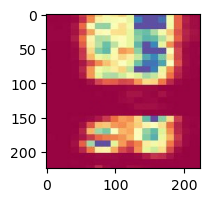

In [3]:
import matplotlib.pyplot as plt
data, label, path = train_data[-1]

plt.figure(figsize=(2, 2))  # 원하는 크기로 조절 (가로, 세로)
plt.imshow(data.permute(1,2,0))
plt.show()

In [4]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch, hidden_dim):
        super(BasicBlock, self).__init__()
        # nn.Module의 모든 것 상속받음
        
        self.conv1 = nn.Conv2d(in_ch, hidden_dim, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_ch, kernel_size=3, padding=0, stride=1)
        self.relu = nn.ReLU()
        #self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        # kernel_size 가 3인경우 3x3의 픽셀에서 feature를 추출하며 이동한다.
        # stride 옵션은 커널이 한 번에 이동하는 간격을 뜻하며 default 1이다.
        
        # in_ch : 입력 채널 수
        # out_ch : 출력 채널 수
        # hiddin_dim : in_ch -> ?? -> out_ch 이 과정을 거칠 때 ?? 의 출력 갯수.
        # 1. (in_ch, hidden_dim) -> 2. (hidden_dim, hidden_dim) -> 3. (hidden_dim, out_ch) 예를 들면 이런식으로 입력 출력 갯수 설정
        
        # stride는 커널의 이동 거리
        
    def forward(self, x): 
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # pytorch는 연산 진행시 자동으로 forward 함수를 호출한다
        # cnn basic : 합성곱 -> 활성화 함수 -> max pooling (차원 감소 + 특징 추출 => 과적합 방지까지 함께 이뤄짐)
        
        return x

In [5]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        self.block1 = BasicBlock(in_ch=3, out_ch=16, hidden_dim=8)
        self.block2 = BasicBlock(in_ch=16, out_ch=32, hidden_dim=24)
        self.block3 = BasicBlock(in_ch=32, out_ch=64, hidden_dim=48)
        # 합성곱 기본 블록 정의
        # in_ch는 rgb 값이므로 처음에 3이 들어감.
        # out_ch는 최종적으로 추출하고싶은 feature의 수를 뜻함. 너무 많으면 속도가 저하되고 너무 적으면 분석이 잘 안됨.
        # 실험을 통해 적절한 값을 찾아야함.
        # hidden_dim은 in_ch와 out_ch 사이의 중간값 정도로 설정해주면 됌.
        
        self.fc1 = nn.Linear(in_features=43264, out_features=10240)
        self.fc2 = nn.Linear(in_features=10240, out_features=2560)
        self.fc3 = nn.Linear(in_features=2560, out_features=512)
        self.fc4 = nn.Linear(in_features=512, out_features=num_classes)
        # num_classes : 유추해야할 target num
        # fc1의 입력 feature가 262144인 이유는 32*32*256이 되기때문  224- > 112 > 64 > 32
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.15)
        
    def forward(self, x): # pytorch는 연산 진행시 자동으로 forward 함수를 호출한다
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x) 
        x = torch.flatten(x, start_dim=1) # 2차원 맵을 1차원으로 펴준다. (MLP 모델의 연산에 사용하기위해)
        # print("After flatten size:", x.size())
        
        x = self.fc1(x)
        x = self.relu(x)
        #x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        #x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.relu(x)
        
        x = self.fc4(x)
        
        return x

In [6]:
from torch.utils.data.dataloader import DataLoader
from collections import defaultdict 
from tqdm.auto import tqdm

batch_size = 20
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


# defaultdict : dict의 key 값이 없는데 호출하면 error가 아닌 default 값을 전달하도록 설정해줌.
train_label_counts = defaultdict(int)
chk_train_loader = tqdm(train_loader)
for data, labels, paths in train_loader:
    for path in paths:
        train_label_counts[path.split('/')[-2]] += 1
        chk_train_loader.set_description(f'Train Set 데이터 수 파악중')
    
    
    
test_label_counts = defaultdict(int)
chk_test_loader = tqdm(test_loader)
for data, labels, paths in test_loader:
    for path in paths:
        test_label_counts[path.split('/')[-2]] += 1
        chk_test_loader.set_description(f'Test Set 데이터 수 파악중')
        
        
print('[Train Data Load Info]')
for value in Categories:
    print(f'폴더 {value:<30}:{train_label_counts[value]}개 load')

print('\n[Train Data Load Info]')
for value in Categories:
    print(f'폴더 {value:<30}:{test_label_counts[value]}개 load')

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Train Data Load Info]
폴더 1. B.C동작_정지                   :1000개 load
폴더 10. 공동구 망치                    :1000개 load
폴더 11. 공동구 드릴                    :1000개 load
폴더 2. B.C동작_가동                   :1000개 load
폴더 3. 주변 설비 진동                   :1000개 load
폴더 4. B.C가동중_이상                  :1000개 load
폴더 5. 이동신호(우향)                   :1000개 load
폴더 6. 이동신호(좌향)                   :1000개 load
폴더 7. 철문신호                       :1000개 load
폴더 8. 포스코 망치                     :1000개 load
폴더 9. 포스코 드릴                     :1000개 load

[Train Data Load Info]
폴더 1. B.C동작_정지                   :100개 load
폴더 10. 공동구 망치                    :100개 load
폴더 11. 공동구 드릴                    :100개 load
폴더 2. B.C동작_가동                   :100개 load
폴더 3. 주변 설비 진동                   :100개 load
폴더 4. B.C가동중_이상                  :100개 load
폴더 5. 이동신호(우향)                   :100개 load
폴더 6. 이동신호(좌향)                   :100개 load
폴더 7. 철문신호                       :100개 load
폴더 8. 포스코 망치                     :50개 load
폴더 9. 포스코 드릴       

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# GPU 메모리 비우기
torch.cuda.empty_cache()

model = CNN(num_classes=len(Categories))

model.to(device) # 정의한 모델을 GPU로 전달

CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU()
    (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU()
    (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU()
    (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Linear(in_features=43264, out_features=10240, bias=True)
  (fc2): Linear(in_features=10240, out_features=2560, bias=True)
  (fc3): Linear(in_features=2560, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=11, bias=True)
  

In [8]:
from tqdm.auto import tqdm
from torch.optim.adam import Adam
import time

lr = 1e-4
optim = Adam(model.parameters(), lr=lr)
# 학습률, 최적화함수 Adam 사용


# 100회 학습 시행
for epoch in range(10):
    iterator = tqdm(train_loader)
    for data, label, path in train_loader:
        optim.zero_grad() # 이전 학습에 대한 기울기 제거 (0으로 초기화)
        preds = model(data.to(device)) 
        # 이미지 값을 gpu로 전달하여 model에 돌린다.
        # 1set : 합성곱-relu-합성곱-relu-맥스풀링
        # 1set - 1set - 1set - flatten (flatten : 이미지값을 1차원 데이터로 만들어주며 MLP 모델에서 연산 가능하게 만들어준다.)
        # MLP 시행 : Linear - Linear - Linear - relu -> 반환
        
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optim.step()
        
        iterator.set_description(f'epoch:{epoch+1} loss:{loss.item():.3f}')

torch.save(model.state_dict(), 'Myung.pth')

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

In [9]:
model.load_state_dict(torch.load('Myung.pth', map_location=device))

num_corr = 0
incorr_img_list = []
all_predict = []
all_true_label = []

index_Categories = {}
for key, value in Categories.items():
    index_Categories[value] = key

with torch.no_grad():
    for data, label, path in test_loader:
        output = model(data.to(device))
        preds = output.data.max(1)[1]
        
        all_predict.extend(preds.tolist())
        all_true_label.extend(label.tolist())
        
        corr_list = preds.eq(label.to(device).data)
        corr = corr_list.sum().item()
        num_corr += corr

        False_Index = [idx for idx, value in enumerate(corr_list.tolist()) if not value]

        if len(False_Index) > 0:
            for index in False_Index:
                incorr_img_list.append({
                    'pred_category' : index_Categories[preds.tolist()[index]],
                    'real_category' : path[index].split('/')[-2],
                    'image' : data[index].cpu().permute(1,2,0),
                    'image_name' : path[index].split('/')[-1]
                })
                
    print(f'정확도({num_corr}/{len(test_data)}) : {num_corr / len(test_data) * 100}%')
    print(f'오답 정보 저장 갯수 : {len(incorr_img_list)}')

정확도(960/1000) : 96.0%
오답 정보 저장 갯수 : 40


오답 갯수 : 40


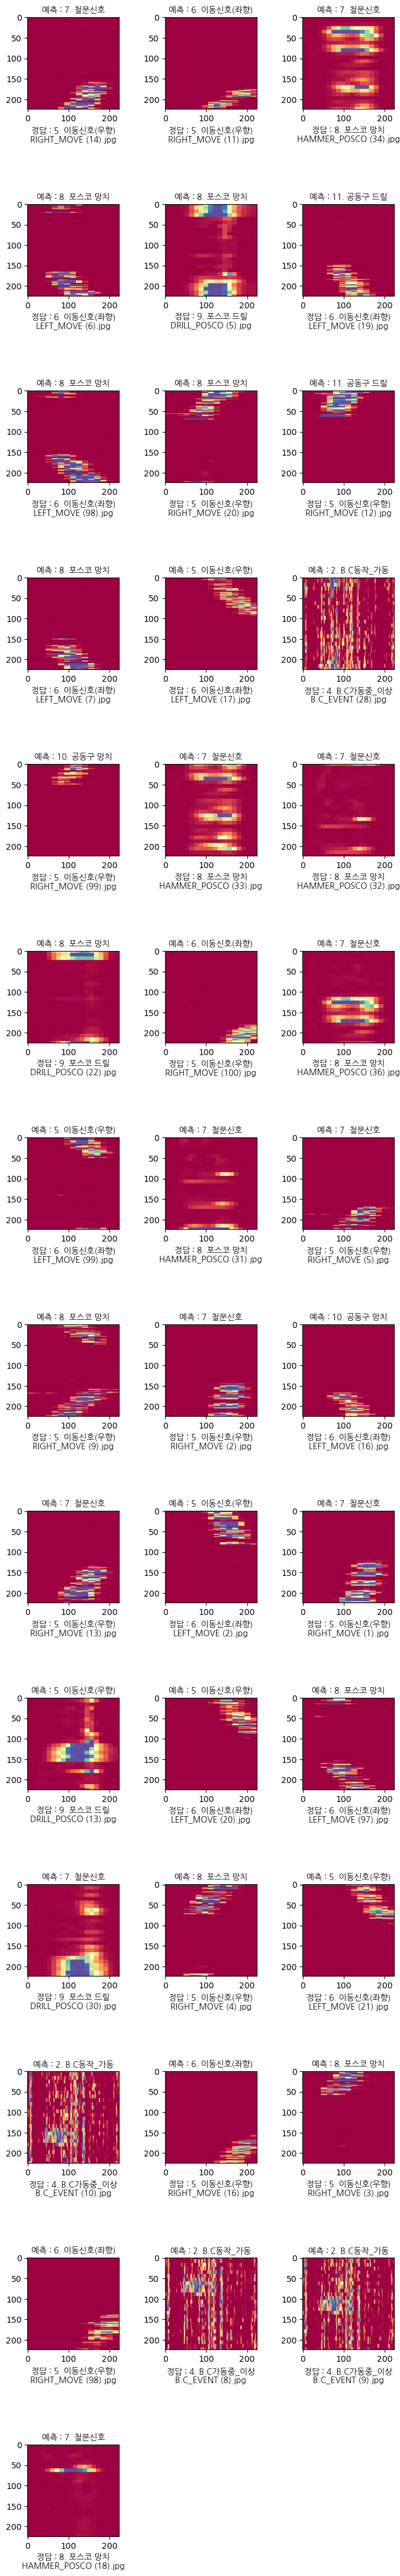

In [10]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"  # 나눔 폰트 경로 설정 (설치한 폰트 경로로 설정)
fontprop = fm.FontProperties(fname=font_path)  # 폰트 매니저에 나눔 폰트 등록

print(f'오답 갯수 : {len(incorr_img_list)}')

# 행과 열의 수 계산
num_rows = len(incorr_img_list) // 3 + 1
num_cols = 3

# 그림 크기 설정
fig = plt.figure(figsize=(8, 56))

for idx in range(len(incorr_img_list)):
    row = idx // num_cols
    col = idx % num_cols

    ax = fig.add_subplot(num_rows, num_cols, idx + 1)
    
    predict_name = incorr_img_list[idx]['pred_category']
    ax.set_title(f'예측 : {predict_name}', fontsize=14, fontproperties=fontprop)
    
    real_folder = incorr_img_list[idx]["real_category"]
    real_file_name = incorr_img_list[idx]["image_name"]
    ax.set_xlabel(f'정답 : {real_folder}\n{real_file_name}', fontproperties=fontprop)
    
    image = incorr_img_list[idx]['image']
    ax.imshow(image)

# 그래프 전체 크기 조절
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

<BarContainer object of 11 artists>

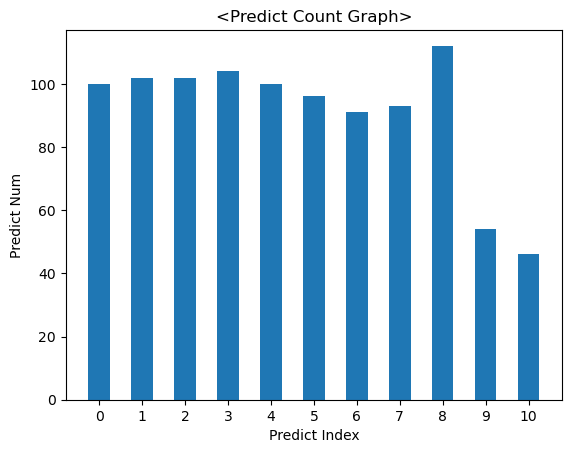

In [11]:
from collections import Counter

class_counts = Counter(all_predict)
sorted_class_counts = sorted(class_counts.items())
count_list_index = [value[0] for value in sorted_class_counts]
count_list_value = [value[1] for value in sorted_class_counts]

plt.title('<Predict Count Graph>')
plt.xlabel('Predict Index')
plt.ylabel('Predict Num')

plt.xticks(count_list_index)
plt.ylim(0, max(count_list_value)+5)

plt.bar(count_list_index, count_list_value, width=0.5)

정답 수 (대각선 갯수 합) : 960
오답 수 (대각선이 아닌 수의 합) : 40
정확도(960/1000) : 96.0%


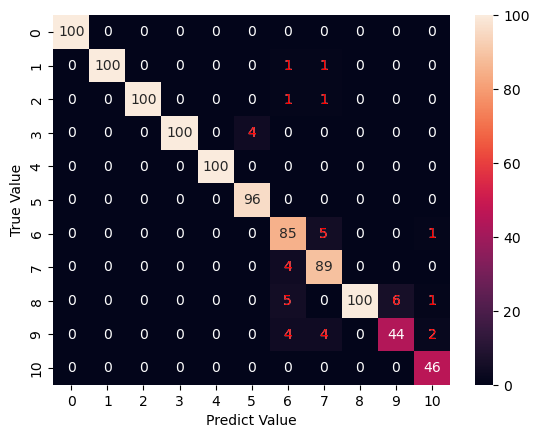

In [12]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

confusion = confusion_matrix(all_predict, all_true_label)

# 대각선에 있는 숫자들의 합 (정확하게 예측한 개수)
correct_predictions = np.trace(confusion)

# 대각선에 없는 숫자들의 합 (오답 개수)
not_correct_predictions = np.sum(confusion) - correct_predictions

print(f'정답 수 (대각선 갯수 합) : {correct_predictions}')
print(f'오답 수 (대각선이 아닌 수의 합) : {not_correct_predictions}')
print(f'정확도({correct_predictions}/{np.sum(confusion)}) : {correct_predictions/np.sum(confusion) * 100}%')

# 오차검증 데이터(cm) 을 색깔 시각화 한다.
# (0,0)에 있는 숫자 -> 0을 0이라고 예측한것 (정답 맞춘거)

ax = sns.heatmap(confusion, annot= True, fmt='d')

# 대각선에 없는 숫자들의 위치 찾기
for i in range(len(confusion)):
    for j in range(len(confusion)):
        if i != j and confusion[i, j] != 0:
            text = ax.text(i + 0.5, i + 0.5, confusion[i, i], color="none")
            text.remove()  # 해당 텍스트 객체를 지움

            ax.text(j+0.5, i+0.5, confusion[i, j], color="red", ha='center', va='center')
            
ax.set_xlabel('Predict Value')
ax.set_ylabel('True Value')

plt.show()

In [15]:
from sklearn.metrics import classification_report

label_list = []

print('[Label 출력]', end='\n\n')
for key, value in Categories.items():
    print(f'{key} : {value}')
    label_list.append(str(value))
    
print('\n\n')

report = classification_report(all_true_label, all_predict, target_names=label_list)
print(report)

[Label 출력]

1. B.C동작_정지 : 0
10. 공동구 망치 : 1
11. 공동구 드릴 : 2
2. B.C동작_가동 : 3
3. 주변 설비 진동 : 4
4. B.C가동중_이상 : 5
5. 이동신호(우향) : 6
6. 이동신호(좌향) : 7
7. 철문신호 : 8
8. 포스코 망치 : 9
9. 포스코 드릴 : 10



              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.98      1.00      0.99       100
           2       0.98      1.00      0.99       100
           3       0.96      1.00      0.98       100
           4       1.00      1.00      1.00       100
           5       1.00      0.96      0.98       100
           6       0.93      0.85      0.89       100
           7       0.96      0.89      0.92       100
           8       0.89      1.00      0.94       100
           9       0.81      0.88      0.85        50
          10       1.00      0.92      0.96        50

    accuracy                           0.96      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.96      0.96      1000

